### Layer-wise Pruning Robustness
Prune each layer removing units iteratively according to the ranking of different attribution metrics. Plot the test loss and accuracy against the number of units that have been removed at each layer.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("./..")

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import matplotlib.pyplot as plt
from torchsummary import summary, torchsummary
from torchpruner import (Pruner, ShapleyAttributionMetric)
from experiments.utils import get_module_name, format_plt, map_method_vis, train, test
import experiments.models.cifar10 as cifar10

from torchpruner import (
    WeightNormAttributionMetric,
    RandomAttributionMetric,
    SensitivityAttributionMetric,
    TaylorAttributionMetric,
    APoZAttributionMetric,
    ShapleyAttributionMetric,
    find_best_module_for_attributions
)

# Fix seed for reproducibility
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print (f"Using device: {device}")

Using device: cuda


In [3]:
# Get pretrained weights
!wget -O weights/CIFAR10-VGG16.pt "https://drive.google.com/u/0/uc?id=164ZfuLwocQRsnXPXKHr6Gbi5Pu7Ikihn&export=download"

--2020-02-14 14:38:02--  https://drive.google.com/u/0/uc?id=164ZfuLwocQRsnXPXKHr6Gbi5Pu7Ikihn&export=download
Resolving drive.google.com (drive.google.com)... 172.217.168.14, 2a00:1450:400a:801::200e
Connecting to drive.google.com (drive.google.com)|172.217.168.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/msbm1e5k7gmgmpmtb4a95ai9jb6ds8u4/1581687000000/04535366121136529507/*/164ZfuLwocQRsnXPXKHr6Gbi5Pu7Ikihn?e=download [following]
--2020-02-14 14:38:03--  https://doc-0o-7s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/msbm1e5k7gmgmpmtb4a95ai9jb6ds8u4/1581687000000/04535366121136529507/*/164ZfuLwocQRsnXPXKHr6Gbi5Pu7Ikihn?e=download
Resolving doc-0o-7s-docs.googleusercontent.com (doc-0o-7s-docs.googleusercontent.com)... 172.217.168.33, 2a00:1450:400a:802::2001
Connecting to doc-0o-7s-docs.googleusercontent.com (doc-0o-7s-d

In [4]:
train_set, test_set = cifar10.get_dataset()
# Using only 1000 samples from test set, just to speed up things a bit.
# Alternatively, this test could be run faster using a forward_partial function
test_set, _ = torch.utils.data.random_split(test_set, [1000, len(test_set)-1000])
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=1000, shuffle=False,
)
x_test, y_test = next(iter(test_loader))
x_test, y_test = x_test.to(device), y_test.to(device)

# Use part of the train data to compute attributions
train_set, _ = torch.utils.data.random_split(train_set, [1000, len(train_set)-1000])
val_loader = torch.utils.data.DataLoader(
    train_set, batch_size=100, shuffle=False,
)
    
loss = cifar10.loss
input_size = (3, 32, 32)

# Load pretrained model
def load_model():
    model, name = cifar10.get_vgg_model_with_name()
    # Load weights
    model.load_state_dict(torch.load("weights/CIFAR10-VGG16.pt"))
    model.to(device)
    model.eval()
    return model

# Display architecture and test performance
model = load_model()
summary(model, input_size=input_size, device=device.type)
original_loss, original_acc = test(model, device, loss, test_loader);

Files already downloaded and verified
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
 

In [5]:
# Construct a function that returns the pruning graph for a VGG network
# The pruning graph is a list of tuples (module, [cascading_modules])
# where module is a prunable 'module' and cascading_modules contains all
# the modules that should be pruned in consequence of 'module' being pruned
def get_pruning_graph(vgg):
    modules = list(vgg.features.children()) + list(vgg.classifier.children())
    pruning = []
    current = None

    for module in modules:
        if any([isinstance(module, c) for c in [nn.Linear, nn.Conv2d]]):
            if current is not None:
                pruning[-1][1].append(module)
                pruning[-1][1].reverse()
            current = module
            pruning.append((module, []))
        elif (
            any([isinstance(module, c) for c in [nn.BatchNorm2d, nn.Dropout]])
            and current is not None
        ):
            pruning[-1][1].append(module)
    return pruning[::-1][1:]

In [6]:
# Initialize attribution metrics that will be used
methods = {
    "Weight Norm" : WeightNormAttributionMetric(model, val_loader, loss, device),
    "Random" : RandomAttributionMetric(model, val_loader, loss, device),
    "Sensitivity" : SensitivityAttributionMetric(model, val_loader, loss, device),
    "Taylor" : TaylorAttributionMetric(model, val_loader, loss, device),
    "Taylor signed" : TaylorAttributionMetric(model, val_loader, loss, device, signed=True),
    "APoZ" : APoZAttributionMetric(model, val_loader, loss, device),
    "SV" : ShapleyAttributionMetric(model, val_loader, loss, device),
    "SV mean+2std" : ShapleyAttributionMetric(model, val_loader, loss, device, 
                                             reduction=lambda x: np.mean(x, 0) + 2*np.std(x, 0))
}

### Run the test, for all layers and all attribution methods

In [7]:
%%time
pruning_graph = get_pruning_graph(model)
print (f"Pruning {len(pruning_graph)} modules...")

log = {}
for module, cascading_modules in pruning_graph:
            
    module_name = get_module_name(model, module)
    log[module_name] = {}
    print (f"Running on {module_name}")
    
    for method_name, attribution in methods.items():
        log[module_name][method_name] = {"loss" : [], "acc" : []}
        pruned_indices = []
        runs = 3 if method_name in ["Random", "SV", "SV mean+2std"] else 1
        
        for r in range(runs):
            print (f"\t--> {method_name} (run {r+1})")
            log[module_name][method_name]["loss"].append([original_loss])
            log[module_name][method_name]["acc"].append([original_acc])

            # Compute attributions on a subset of the train data
            # `find_best_evaluation_module=True` makes sure attributions are computed
            # after BatchNorm and non-linearity
            scores = attribution.run(module, find_best_evaluation_module=True)
            ranking = np.argsort(scores)

            with torch.no_grad():
                # Start ablation procedure, measuring performance on the test data
                # We use simulated pruning (activations masked to zero)
                
                # 0. Find the next ReLU module, because pruning should happen after BN and non-linearity
                # Notice that VGG is composed by Conv -> BN -> ReLU blocks
                # During structured pruning, both Conv and BN are pruned, therefore
                # masking should happen at least after BN.
                module_nl = find_best_module_for_attributions(model, module)
                
                # 1. Compute activation of current module/layer.
                z = model.forward_partial(x_test, to_module=module_nl)

                # 2. Remove activations sequentially, starting with those having lowest attributions
                for i in ranking:
                    z.index_fill_(1, torch.tensor([i]).to(device), 0.)
                    y_pred = model.forward_partial(z, from_module=module_nl)
                    new_loss = loss(y_pred, y_test)
                    current_pred = y_pred.argmax(dim=1, keepdim=True)
                    new_acc = current_pred.eq(y_test.view_as(current_pred)).sum().float() / len(y_test)
                    log[module_name][method_name]["loss"][-1].append(new_loss.item())
                    log[module_name][method_name]["acc"][-1].append(new_acc.item())

# Dump all results to file for later analysis
pickle.dump(log, open("data/layerwise_pruning_results.p", "wb" ))

Pruning 15 modules...
Running on classifier.4
	--> Weight Norm (run 1)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Random (run 1)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Random (run 2)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Random (run 3)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Sensitivity (run 1)
Activation detected: shifting evaluation after ReLU(inplace=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Taylor (run 1)
Activation detected: shifting evaluation after ReLU(inplace=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Taylor signed (run 1)
Activation detected: shifting evaluation after ReLU(inplace=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> APoZ (run 1)
Activation detected: shifting evaluation after ReLU(inplace=True)
Activation detected: shifting evaluation after ReLU(i

	--> SV mean+2std (run 3)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Running on features.37
	--> Weight Norm (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Random (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Random (run 2)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running

	--> SV (run 2)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> SV (run 3)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> SV mean+2std (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation af

	--> Taylor (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Taylor signed (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> APoZ (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evalua

	--> SV mean+2std (run 3)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Running on features.20
	--> Weight Norm (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Random (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Random (run 2)
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

	--> SV (run 2)
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> SV (run 3)
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> SV mean+2std (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation af

	--> Taylor (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Taylor signed (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> APoZ (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evalua

	--> SV mean+2std (run 3)
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
Running on features.3
	--> Weight Norm (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Random (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> Random (run 2)
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

	--> SV (run 2)
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> SV (run 3)
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after ReLU(inplace=True)
	--> SV mean+2std (run 1)
BatchNorm detected: shifting evaluation after BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation detected: shifting evaluation after R

### Plot the results

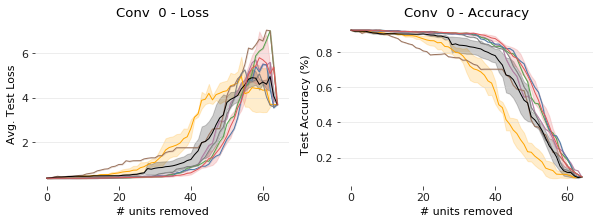

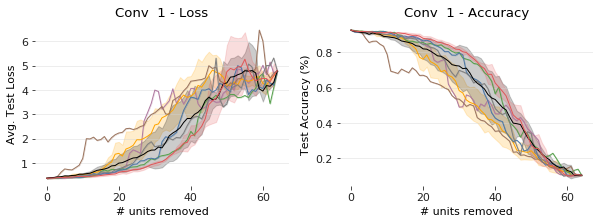

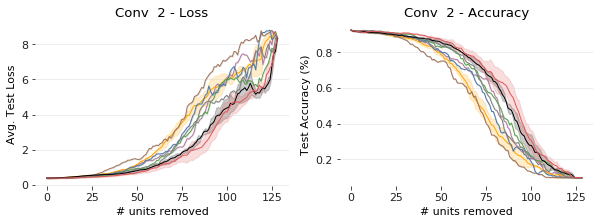

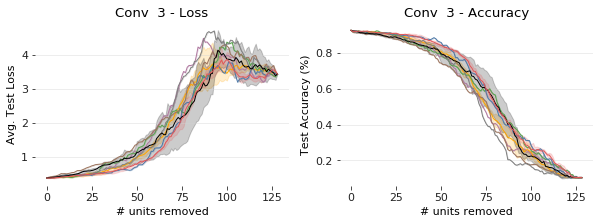

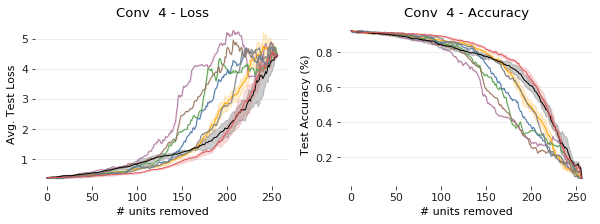

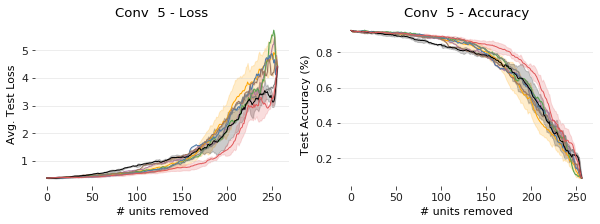

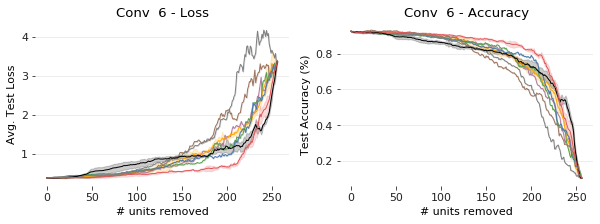

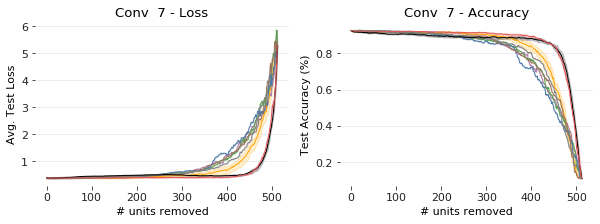

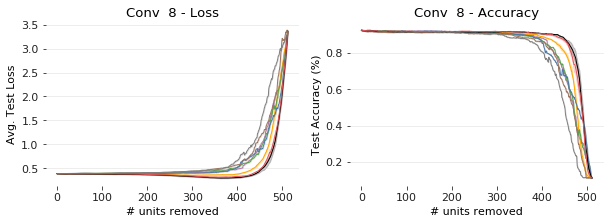

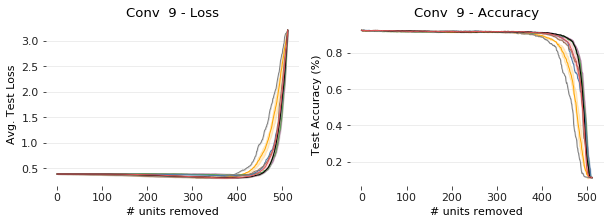

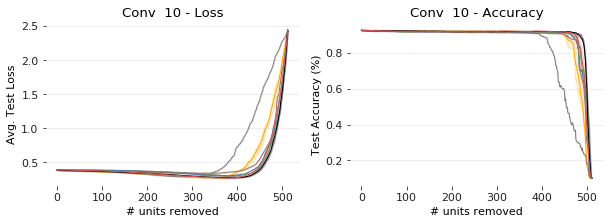

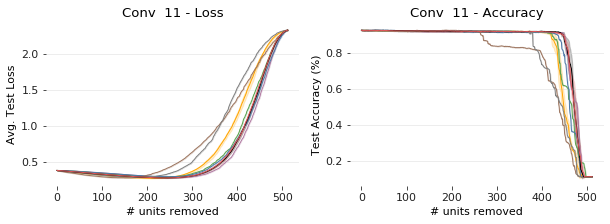

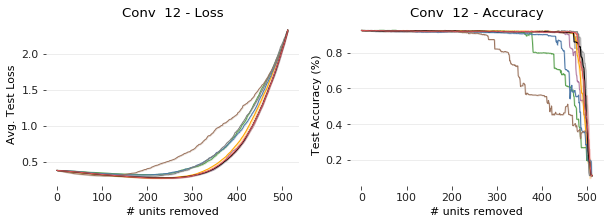

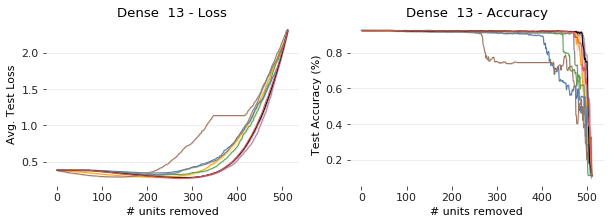

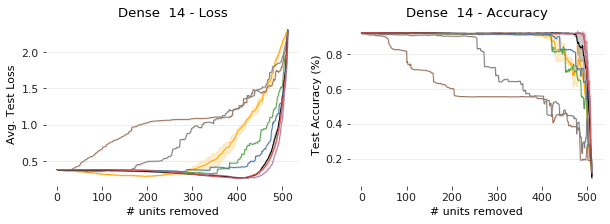

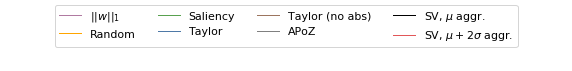

In [13]:
# Load the data from previously stored results
# and sort layers
plot_data = pickle.load(open("data/layerwise_pruning_results.p", "rb" ))
layers = plot_data.keys()
layers = sorted(layers, key=lambda x: -int(x.split(".")[1]), reverse=True)
layers = sorted(layers, key=lambda x: 0 if "classifier" in x else 1, reverse=True)

# Some general settings
plt.rcParams.update({'font.size': 11})

auc = {}
for idx, layer_id in enumerate(layers):
    layer_data = plot_data[layer_id]
    layer_name = f"{'Conv ' if 'features' in layer_id else 'Dense '} {idx}"
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(10,3.0));
    
    for method_name, data in layer_data.items(): 
        label, color = map_method_vis(method_name)
        ticks = range(len(data["loss"][0]))
        loss_mean = np.mean(data["loss"], 0)
        loss_std = np.std(data["loss"], 0)
        acc_mean = np.mean(data["acc"], 0)
        acc_std = np.std(data["acc"], 0)
        
        # AUC
        auc_layer = np.sum(np.array(data["loss"]) - data["loss"][0][0], 1)
        n_units = len(data["loss"][0]) - 1
        if method_name not in auc:
            auc[method_name] = {"sum": auc_layer, "count": n_units}
        else:
            auc[method_name]["sum"] += auc_layer
            auc[method_name]["count"] += n_units
        
        # Plot with confidence intervals
        ax_loss.fill_between(ticks, loss_mean + loss_std, loss_mean - loss_std, alpha=.2, color=color);
        ax_loss.plot(ticks, loss_mean, label=label, color=color, lw=1);
        format_plt(ax_loss, f"{layer_name} - Loss", "# units removed", "Avg. Test Loss")

        ax_acc.fill_between(ticks, acc_mean + acc_std, acc_mean - acc_std, alpha=.2, color=color);
        ax_acc.plot(ticks, acc_mean, label=label, color=color, lw=1);
        format_plt(ax_acc, f"{layer_name} - Accuracy", "# units removed", "Test Accuracy (%)")
        # plt.savefig(f"cifar10_robustness_study_{layer_name}.pdf", bbox_inches='tight')
        

# Plot a single legend below
handles, labels = ax_loss.get_legend_handles_labels()
handles, labels  = zip(*sorted(zip(handles, labels), key=lambda t: 1 if "SV" in t[1] else -1))
fig = plt.figure(figsize=(10, 1))
fig.add_subplot(111)
plt.box(False)
plt.axis('off')
fig.legend(handles, labels,loc='upper center', ncol=4);
# plt.savefig(f"cifar10_robustness_study_legend.pdf", bbox_inches='tight')

In [10]:
# Print AUC
for method_name, auc_method in auc.items():
    s = auc_method["sum"]
    c = auc_method["count"] 
    print (f"{method_name} \n {np.mean(s/c, 0):.2f} +- {np.std(s/c, 0):.2f}")

Weight Norm 
 0.47 +- 0.00
Random 
 0.48 +- 0.01
Sensitivity 
 0.47 +- 0.00
Taylor 
 0.47 +- 0.00
Taylor signed 
 0.64 +- 0.00
APoZ 
 0.56 +- 0.00
SV 
 0.35 +- 0.01
SV mean+2std 
 0.31 +- 0.00
